Overview: Complex Fit
=====================

In this example, we'll fit 1D data of a `Gaussian` and Exponential profile with a 1D `Gaussian` + Exponential model
using MCMC, nested sampling and optimization non-linear searches.

In [1]:
%matplotlib inline

import autofit as af

import matplotlib.pyplot as plt
import numpy as np
import os
from os import path

At the top of every tutorial notebook, you'll see the following cell. This cell uses the project `pyprojroot` to
locate the path to the workspace on your computer and use it to set the working directory of the notebook.

In [2]:
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

C:\Users\Jammy\Code\PyAuto\autofit_workspace
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\autofit_workspace`


__Data__

First, lets load data of a 1D `Gaussian` + 1D `Exponential`, by loading it from a .json file in the directory
`autofit_workspace/dataset//gaussian_x1__exponential_x1`.

In [3]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1__exponential_x1")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Now lets plot the data, including its error bars. We'll use its shape to determine the xvalues of the
data for the plot.

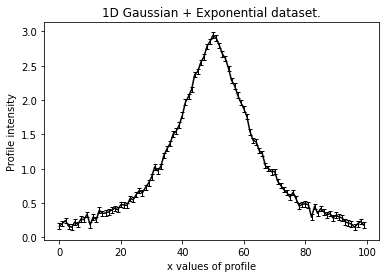

In [4]:
xvalues = range(data.shape[0])
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.title("1D Gaussian + Exponential dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Model__

Next, we create our model, which in this case corresponds to a `Gaussian` + Exponential.

We therefore need two classes, one for each model component.

In [5]:
class Gaussian:

    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these constructor arguments
        intensity=0.1,  # <- are the Gaussian`s model parameters.
        sigma=0.01,
    ):
        """Represents a 1D `Gaussian` profile, which may be treated as a model-component of PyAutoFit the
        parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre : float
            The x coordinate of the profile centre.
        intensity : float
            Overall intensity normalisation of the `Gaussian` profile.
        sigma : float
            The sigma value controlling the size of the Gaussian.
        """

        self.centre = centre
        self.intensity = intensity
        self.sigma = sigma

    def profile_from_xvalues(self, xvalues):
        """
        Calculate the intensity of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, using its centre.

        Parameters
        ----------
        values : np.ndarray
            The x coordinates in the original reference frame of the grid.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.intensity, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )

In [6]:
class Exponential:
    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these constructor arguments are the model
        intensity=0.1,  # <- parameters of the Exponential.
        rate=0.01,
    ):
        """Represents a 1D Exponential profile symmetric about a centre, which may be treated as a model-component
        of PyAutoFit the parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre : float
            The x coordinate of the profile centre.
        intensity : float
            Overall intensity normalisation of the `Gaussian` profile.
        ratw : float
            The decay rate controlling has fast the Exponential declines.
        """

        self.centre = centre
        self.intensity = intensity
        self.rate = rate

    def profile_from_xvalues(self, xvalues):
        """
        Calculate the intensity of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Exponential, using its centre.

        Parameters
        ----------
        values : np.ndarray
            The x coordinates in the original reference frame of the grid.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return self.intensity * np.multiply(
            self.rate, np.exp(-1.0 * self.rate * abs(transformed_xvalues))
        )

The `Gaussian` has 3 parameters (centre, intensity and sigma) and Exponential 3 parameters (centre, intensity and
rate). These are the free parameters of our model that the `NonLinearSearch` fits for, meaning the non-linear
parameter space has dimensionality = 6.

In the simple example tutorial, we used a `PriorModel` to create the model of the Gaussian. `PriorModel'`s do not compose
models from multiple model components and for this example we must instead use the `CollectionPriorModel`.

In [7]:
model = af.CollectionPriorModel(gaussian=Gaussian, exponential=Exponential)

The priors for the `Gaussian` module component are loaded from the priors specified
in `autofit_workspace/config/priors`, which we can print to view.

In [8]:
print(model)

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 25.0), Exponential (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (rate, UniformPrior, lower_limit = 0.0, upper_limit = 1.0)


More details on prior configs are given in the **HowToFit** tutorials.

We can manually over-ride the priors with our own as follows:


In [9]:
model.gaussian.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.gaussian.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=1e2)
model.gaussian.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=30.0)
model.exponential.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.exponential.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=1e2)
model.exponential.rate = af.UniformPrior(lower_limit=0.0, upper_limit=1.0)

print(model)

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 30.0), Exponential (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (rate, UniformPrior, lower_limit = 0.0, upper_limit = 1.0)


Above, we named our model-components: we called the `Gaussian` component `gaussian` and Exponential component
`exponential`. We could have chosen anything for these names, as shown by the code below.

In [10]:
model_custom_names = af.CollectionPriorModel(custom_name=Gaussian, another_custom_name=Exponential)

model_custom_names.custom_name.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model_custom_names.custom_name.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=1e2)
model_custom_names.custom_name.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=30.0)
model_custom_names.another_custom_name.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model_custom_names.another_custom_name.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=1e2)
model_custom_names.another_custom_name.rate = af.UniformPrior(lower_limit=0.0, upper_limit=1.0)

print(model)

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 30.0), Exponential (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (rate, UniformPrior, lower_limit = 0.0, upper_limit = 1.0)


The naming of model components is important - as these names will are adotped by the instance pass to the Analysis
class and the results returned by the non-linear search.

we'll use the `model` variable from here on, with the more sensible names of `gaussian` and `exponential`.

__Analysis__

We now set up our Analysis, which describes how given an instance of our model (a `Gaussian` + Exponential) we fit the
data and return a log likelihood value.

In [11]:
class Analysis(af.Analysis):

    """
    In this example the Analysis only contains the data and noise-map. It can be easily extended however, for more
    complex data-sets and model fitting problems.
    """

    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    """
    In the log_likelihood_function function below, `instance` is an instance of our model, which in this example is
    an instance of the `Gaussian` class and Exponential class in `model.py`. Their parameters are set via the
    non-linear search. This gives us the instance of the model we need to fit our data!
    """

    def log_likelihood_function(self, instance):
        """
        Determine the log likelihood of a fit of multiple profiles to the dataset.

        Parameters
        ----------
        instance : af.CollectionPriorModel
            The model instances of the profiles.

        Returnsn
        -------
        fit : Fit.log_likelihood
            The log likelihood value indicating how well this model fit the dataset.
        """

        """
        The `instance` that comes into this method is a CollectionPriorModel. It contains instances of every class
        we instantiated it with, where each instance is named following the names given to the CollectionPriorModel,
        which in this example is a `Gaussian` (with name `gaussian) and Exponential (with name `exponential`):
        """

        # print("Gaussian Instance:")
        # print("Centre = ", instance.gaussian.centre)
        # print("Intensity = ", instance.gaussian.intensity)
        # print("Sigma = ", instance.gaussian.sigma)

        # print("Exponential Instance:")
        # print("Centre = ", instance.exponential.centre)
        # print("Intensity = ", instance.exponential.intensity)
        # print("Rate = ", instance.exponential.rate)

        """Get the range of x-values the data is defined on, to evaluate the model of the profiles."""
        xvalues = np.arange(self.data.shape[0])

        """
        The simplest way to create the summed profile is to add the profile of each model component. If we
        know we are going to fit a `Gaussian` + Exponential we can do the following:

            model_data_gaussian = instance.gaussian.profile_from_xvalues(xvalues=xvalues)
            model_data_exponential = instance.exponential.profile_from_xvalues(xvalues=xvalues)
            model_data = model_data_gaussian + model_data_exponential

        However, this does not work if we change our model components. However, the *instance* variable is a list of
        our model components. We can iterate over this list, calling their profile_from_xvalues and summing the result
        to compute the summed profile of any model.
        """

        """Use these xvalues to create model data of our profiles."""
        model_data = sum(
            [line.profile_from_xvalues(xvalues=xvalues) for line in instance]
        )

        """Fit the model profile data to the observed data, computing the residuals and chi-squareds."""
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood

    def visualize(self, paths, instance, during_analysis):

        """
        During a model-fit, the `visualize` method is called throughout the non-linear search. The `instance` passed
        into the visualize method is maximum log likelihood solution obtained by the model-fit so far and it can be
        used to provide on-the-fly images showing how the model-fit is going.
        """

        xvalues = np.arange(self.data.shape[0])

        model_datas = [line.profile_from_xvalues(xvalues=xvalues) for line in instance]
        model_data = sum(model_datas)

        plt.errorbar(
            x=xvalues, y=self.data, yerr=self.noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
        )
        plt.plot(range(self.data.shape[0]), model_data, color="r")
        for model_data_individual in model_datas:
            plt.plot(range(self.data.shape[0]), model_data_individual, "--")
        plt.title("Dynesty model fit to 1D Gaussian + Exponential dataset.")
        plt.xlabel("x values of profile")
        plt.ylabel("Profile intensity")

        os.makedirs(paths.image_path, exist_ok=True)
        plt.savefig(path.join(paths.image_path, "model_fit.png"))
        plt.clf()

For this simple example, we only have to pass it the data and its noise-map.

In [12]:
analysis = Analysis(data=data, noise_map=noise_map)

NESTED SAMPLING
---------------

We finally choose and set up our non-linear search. we'll first fit the data with the nested sampling algorithm
Dynesty. Below, we manually specify all of the Dynesty settings, however if we omitted them the default values
found in the config file `config/non_linear/Dynesty.ini` would be used.

For a full description of Dynesty checkout its Github and documentation webpages:

https://github.com/joshspeagle/dynesty
https://dynesty.readthedocs.io/en/latest/index.html

In [13]:
dynesty = af.DynestyStatic(
    path_prefix=path.join("overview", "complex"),
    n_live_points=60,
    bound="multi",
    sample="auto",
    bootstrap=0,
    enlarge=-1,
    update_interval=-1.0,
    vol_dec=0.5,
    vol_check=2.0,
    walks=25,
    facc=0.5,
    slices=5,
    fmove=0.9,
    max_move=100,
    iterations_per_update=500,
    number_of_cores=1,
)

To perform the fit with Dynesty, we pass it our model and analysis and we`re good to go!

Checkout the folder `autofit_workspace/output/dynestystatic`, where the `NonLinearSearch` results, visualization and
information can be found.

In [14]:
result = dynesty.fit(model=model, analysis=analysis)

INFO:root: already completed, skipping non-linear search.


The result object returned by the fit provides information on the results of the non-linear search. Lets use it to
compare the maximum log likelihood `Gaussian` + Exponential model to the data.

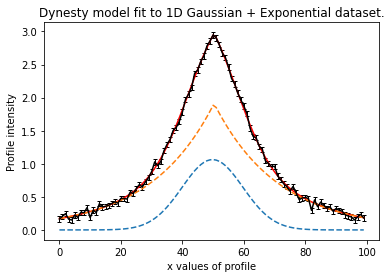

In [15]:
instance = result.max_log_likelihood_instance

model_gaussian = instance.gaussian.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_exponential = instance.exponential.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_data = model_gaussian + model_exponential

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), model_gaussian, "--")
plt.plot(range(data.shape[0]), model_exponential, "--")
plt.title("Dynesty model fit to 1D Gaussian + Exponential dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

We discuss in more detail how to use a results object in the files `autofit_workspace/example/results`.

MCMC
----

To use a different non-linear we simply use call a different search from **PyAutoFit**, passing it the same the model
and analysis as we did before to perform the fit. Below, we fit the same dataset using the MCMC sampler Emcee.
Again, we manually specify all of the Emcee settings, however if they were omitted the values found in the config
file `config/non_linear/Emcee.ini` would be used instead.

For a full description of Emcee, checkout its Github and readthedocs webpages:

https://github.com/dfm/emcee
https://emcee.readthedocs.io/en/stable/

**PyAutoFit** extends **emcee** by providing an option to check the auto-correlation length of the samples
during the run and terminating sampling early if these meet a specified threshold. See this page
(https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr) for a description of how this is implemented.

In [16]:
emcee = af.Emcee(
    path_prefix=path.join("overview", "complex"),
    nwalkers=50,
    nsteps=2000,
    initializer=af.InitializerBall(lower_limit=0.49, upper_limit=0.51),
    auto_correlation_check_for_convergence=True,
    auto_correlation_check_size=100,
    auto_correlation_required_length=50,
    auto_correlation_change_threshold=0.01,
    number_of_cores=1,
)

In [17]:
result = emcee.fit(model=model, analysis=analysis)

INFO:root: already completed, skipping non-linear search.


The result object returned by Emcee`s fit is similar in structure to the Dynesty result above - it again provides
us with the maximum log likelihood instance.

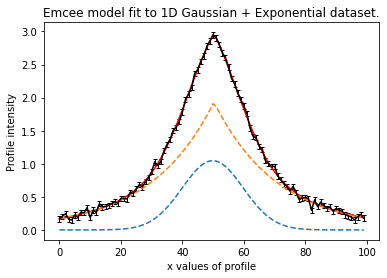

In [18]:
instance = result.max_log_likelihood_instance

model_gaussian = instance.gaussian.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_exponential = instance.exponential.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_data = model_gaussian + model_exponential

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), model_gaussian, "--")
plt.plot(range(data.shape[0]), model_exponential, "--")
plt.title("Emcee model fit to 1D Gaussian + Exponential dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

Optimizer
---------

**PyAutoFit** also supports optimizer searches, which aim to find the global (or local) maxima likelihood solution.
Unlike nested samplers and MCMC algorithms, they do not extensively map out parameter space. This means they can find
the best solution a lot faster than these algorithms, but they do not properly quantify the errors on each parameter.

we'll use the Particle Swarm Optimization algorithm PySwarms. For a full description of PySwarms, checkout its Github 
and readthedocs webpages:

https://github.com/ljvmiranda921/pyswarms
https://pyswarms.readthedocs.io/en/latest/index.html

**PyAutoFit** extends *PySwarms* by allowing runs to be terminated and resumed from the point of termination, as well
as providing different options for the initial distribution of particles.

In [22]:
pso = af.PySwarmsGlobal(
    path_prefix=path.join("overview", "complex"),
    n_particles=500,
    iters=300,
    cognitive=0.5,
    social=0.3,
    inertia=0.9,
    ftol=-np.inf,
    initializer=af.InitializerPrior(),
    number_of_cores=1,
)
result = pso.fit(model=model, analysis=analysis)

2021-02-06 13:09:39,026 - root - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2021-02-06 13:09:39,814 - root - INFO - No PySwarms samples found, beginning new non-linear search. 
2021-02-06 13:09:39,815 - root - INFO - Running PySwarmsGlobal Optimizer...
2021-02-06 13:09:39,821 - pyswarms.single.global_best - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|300/300, best_cost=92.7 
2021-02-06 13:12:53,565 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 92.66028563201525, best pos: [4.97512979e+01 2.72954370e+01 9.95611527e+00 5.03816505e+01
 3.94774325e+01 4.75072148e-02]
2021-02-06 13:12:53,579 - root - INFO - 500 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-02-06 13:13:06,800 - root - INFO - PySwarmsGlobal complete
2021-02-06 13:13:06,805 - root - INFO - 1000 Iterations: Performing update (Visualization, out

<Figure size 432x288 with 0 Axes>

The result object returned by PSO is again very similar in structure to previous results.

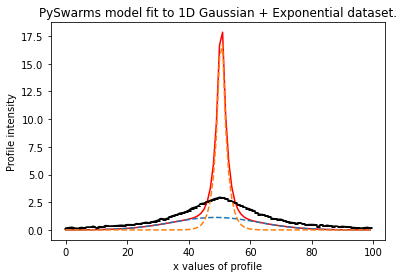

In [23]:
instance = result.max_log_likelihood_instance

model_gaussian = instance.gaussian.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_exponential = instance.exponential.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_data = model_gaussian + model_exponential

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), model_gaussian, "--")
plt.plot(range(data.shape[0]), model_exponential, "--")
plt.title("PySwarms model fit to 1D Gaussian + Exponential dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Other Searches__

Checkout https://pyautofit.readthedocs.io/en/latest for the non-linear searches available in **PyAutoFit**.